In [1]:
from sklearnex import patch_sklearn 

patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import module as mod

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.semi_supervised import SelfTrainingClassifier

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1. Import et nettoyage des données

In [2]:
house1_power_blk2 = mod.load_dataset('data/house1_power_blk2_labels.zip')
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.0
2016-03-06 00:00:01,474.0,0,0.0
2016-03-06 00:00:02,476.0,0,0.0
2016-03-06 00:00:03,476.0,0,0.0
2016-03-06 00:00:04,475.0,0,0.0


In [3]:
house2_power_blk1 = mod.load_dataset('data/house2_power_blk1_labels.zip')
house2_power_blk1.head()

,mains,activity,hour
datetime,,,
2017-09-12 23:00:00,103.0,0,23.0
2017-09-12 23:00:01,101.0,0,23.0
2017-09-12 23:00:02,104.0,0,23.0
2017-09-12 23:00:03,104.0,0,23.0
2017-09-12 23:00:04,105.0,0,23.0


In [4]:
windows = ['1h', '10min']
features_col = ['mains', 'hour']

house1_power_blk2, _ = mod.generate_features(house1_power_blk2, window=windows)
house2_power_blk1, cols = mod.generate_features(house2_power_blk1, window=windows)
features_col += cols

## Résultats sur une seule maison
Nous allons ici faire un récapitulatif des meilleurs socres obtenus pour chaque famille d'algorithmes pour les deux maisons.

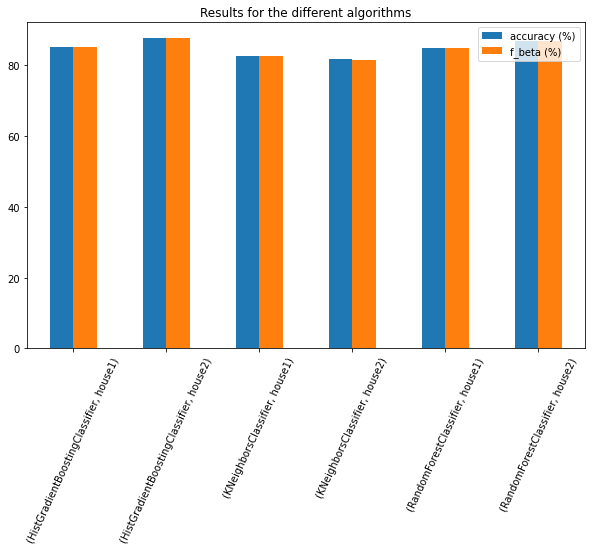

In [17]:
results = {}
results[('KNeighborsClassifier', 'house1')] = {'accuracy (%)': 82.432, 'f_beta (%)': 82.562}
results[('RandomForestClassifier', 'house1')] = {'accuracy (%)': 84.831, 'f_beta (%)': 84.803}
results[('HistGradientBoostingClassifier', 'house1')] = {'accuracy (%)': 84.992, 'f_beta (%)': 85.009}

results[('KNeighborsClassifier', 'house2')] = {'accuracy (%)': 81.619, 'f_beta (%)': 81.481}
results[('RandomForestClassifier', 'house2')] = {'accuracy (%)': 86.864, 'f_beta (%)': 86.677}
results[('HistGradientBoostingClassifier', 'house2')] = {'accuracy (%)': 87.522, 'f_beta (%)': 87.679}
results = pd.DataFrame(results).T.sort_index()

results.plot(kind='bar', figsize=(10, 6));
plt.xticks(rotation=65)
plt.title('Results for the different algorithms');

# 2. Algorithmes généraux : house 1 vs house 2

In [5]:
scaler = StandardScaler()
sample_idx = mod.pick_random_indexes(house2_power_blk1, 0.3)
X_train = scaler.fit_transform(house1_power_blk2[features_col].values)
X_test = scaler.transform(house2_power_blk1.loc[sample_idx, features_col].values)

y_train = house1_power_blk2['activity'].values
y_test = house2_power_blk1.loc[sample_idx, 'activity'].values

Score f_beta : 65.801%
Score accuracy : 66.630%


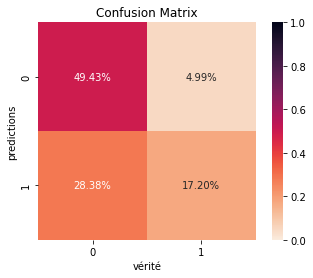

In [8]:
knn = KNeighborsClassifier(n_neighbors=90, n_jobs=-1)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

Score f_beta : 63.009%
Score accuracy : 64.925%


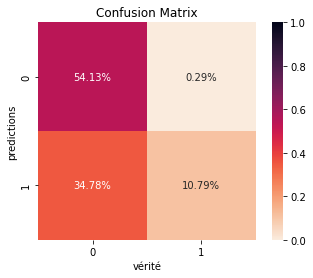

In [9]:
rfc = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12)
rfc.fit(X_train, y_train.ravel())
y_pred = rfc.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

Score f_beta : 64.408%
Score accuracy : 65.704%


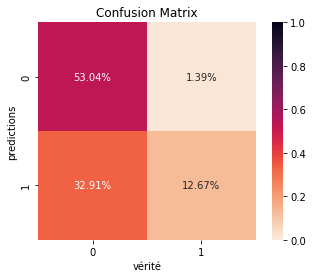

In [10]:
hgbc = HistGradientBoostingClassifier()
hgbc.fit(X_train, y_train.ravel())
y_pred = hgbc.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

# 3. Algorithmes généraux : house 2 vs house 1
## 3.1 Scaler fitté sur la maison 2

In [5]:
scaler = MinMaxScaler()
sample_idx = mod.pick_random_indexes(house1_power_blk2, 0.3)
X_train = scaler.fit_transform(house2_power_blk1[features_col].values)
# Attention : ici on re-fit le scaler sur les données de la maison 2 (test)
X_test = scaler.transform(house1_power_blk2.loc[sample_idx, features_col].values)

y_train = house2_power_blk1['activity'].values
y_test = house1_power_blk2.loc[sample_idx, 'activity'].values

Score f_beta : 59.109%
Score accuracy : 59.319%


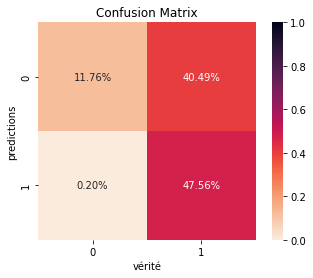

In [6]:
knn = KNeighborsClassifier(n_neighbors=90, n_jobs=-1)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

Score f_beta : 26.686%
Score accuracy : 47.759%


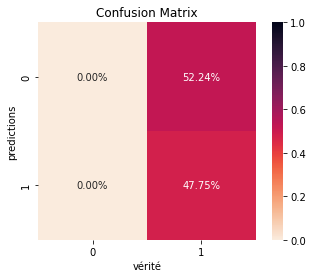

In [7]:
rfc = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12)
rfc.fit(X_train, y_train.ravel())
y_pred = rfc.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

Score f_beta : 27.611%
Score accuracy : 47.269%


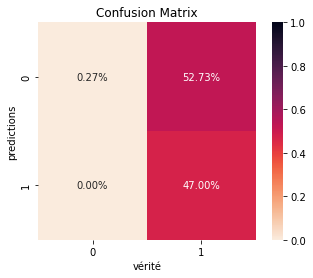

In [9]:
hgbc = HistGradientBoostingClassifier()
hgbc.fit(X_train, y_train.ravel())
y_pred = hgbc.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

## 3.2 Scaler fitté sur la maison 1
Essayons avec une fenêtre de 7 jour avec un ```MinMaxScaler```

In [9]:
scaler = MinMaxScaler()
sample_idx = mod.pick_random_indexes(house1_power_blk2, 0.3)
X_train = scaler.fit_transform(house2_power_blk1[features_col].values)
# Attention : ici on re-fit le scaler sur les données de la maison 1 (test) sur 7 jours
scaler.fit(house1_power_blk2.iloc[:24*60*60*7,:].loc[:, features_col].values)
X_test = scaler.transform(house1_power_blk2.loc[sample_idx, features_col].values)

y_train = house2_power_blk1['activity'].values
y_test = house1_power_blk2.loc[sample_idx, 'activity'].values

Score f_beta : 75.084%
Score accuracy : 74.337%


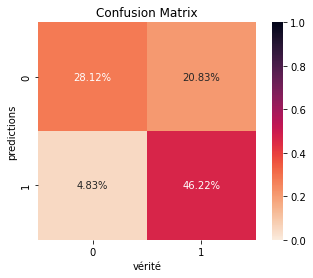

In [10]:
knn = KNeighborsClassifier(n_neighbors=90, n_jobs=-1)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

Score f_beta : 76.405%
Score accuracy : 74.827%


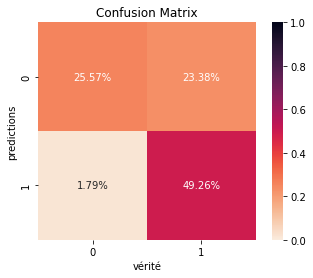

In [11]:
rfc = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12)
rfc.fit(X_train, y_train.ravel())
y_pred = rfc.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

Score f_beta : 75.030%
Score accuracy : 73.480%


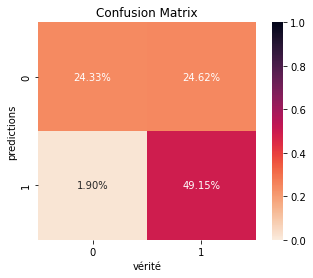

In [13]:
hgbc = HistGradientBoostingClassifier()
hgbc.fit(X_train, y_train.ravel())
y_pred = hgbc.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

On peut essayer plusieurs fenêtres de temps, toujours avec un ```MinMaxScaler``` et un ```RandomForestClassifier```.

In [5]:
def classif_scale_window(data_train, data_test, window=1, classifier=HistGradientBoostingClassifier(), scaler=MinMaxScaler()):
    
    #sample_idx = mod.pick_random_indexes(house1_power_blk2, 0.3)
    X_train = scaler.fit_transform(data_train[features_col].values)
    # Attention : ici on re-fit le scaler sur les données du test
    scaler.fit(data_test.iloc[:24*60*60*window,:].loc[:, features_col].values)
    X_test = scaler.transform(data_test.iloc[24*60*60*window:,:].loc[:, features_col].values)

    y_train = data_train['activity'].values
    y_test = data_test.iloc[24*60*60*window:,:].loc[:, 'activity'].values

    classifier.fit(X_train, y_train.ravel())
    y_pred = classifier.predict(X_test)

    f_beta = fbeta_score(y_test, y_pred, average="macro", beta=0.5)
    acc = accuracy_score(y_test, y_pred)

    return f_beta, acc

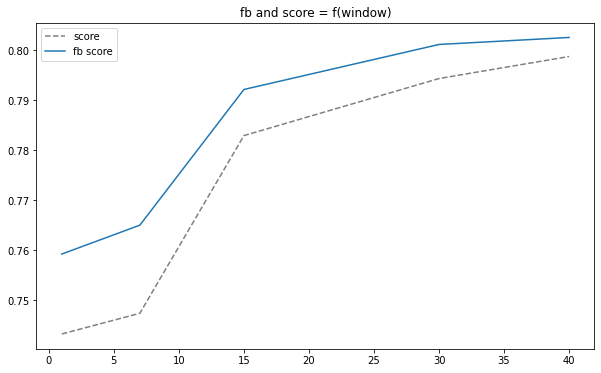

In [6]:
w_range = [1, 7, 15, 30, 40]
fb_score = []
acc_score = []
for w in w_range:
    fb, acc = classif_scale_window(house2_power_blk1, house1_power_blk2, window=w, classifier=RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12))
    fb_score.append(fb)
    acc_score.append(acc)

plt.figure(figsize=(10, 6));
plt.plot(w_range, acc_score, label='score', color='grey', linestyle='dashed');
plt.plot(w_range, fb_score, label='fb score');
plt.legend();
plt.title('fb and score = f(window)');


Essayons avec un ```StandardScaler```.

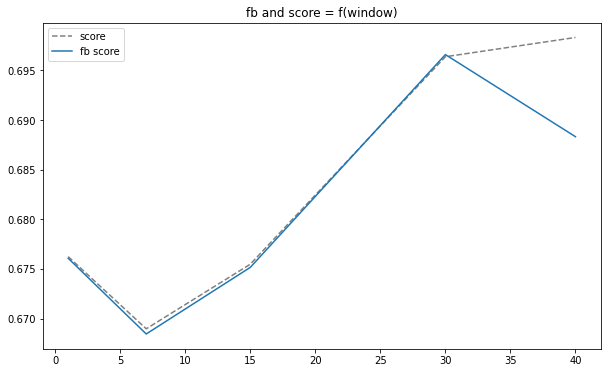

In [7]:
w_range = [1, 7, 15, 30, 40]
fb_score = []
acc_score = []
for w in w_range:
    fb, acc = classif_scale_window(house2_power_blk1, house1_power_blk2, window=w, classifier=RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12), scaler=StandardScaler())
    fb_score.append(fb)
    acc_score.append(acc)

plt.figure(figsize=(10, 6));
plt.plot(w_range, acc_score, label='score', color='grey', linestyle='dashed');
plt.plot(w_range, fb_score, label='fb score');
plt.legend();
plt.title('fb and score = f(window)');


Essayons avec un ```QuantileTransformer```

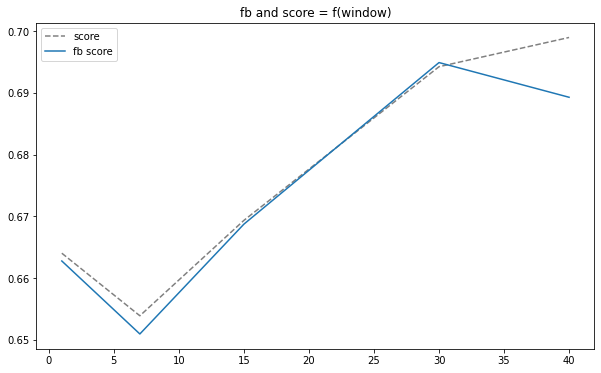

In [8]:
w_range = [1, 7, 15, 30, 40]
fb_score = []
acc_score = []
for w in w_range:
    fb, acc = classif_scale_window(house2_power_blk1, house1_power_blk2, window=w, classifier=RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12), scaler=QuantileTransformer())
    fb_score.append(fb)
    acc_score.append(acc)

plt.figure(figsize=(10, 6));
plt.plot(w_range, acc_score, label='score', color='grey', linestyle='dashed');
plt.plot(w_range, fb_score, label='fb score');
plt.legend();
plt.title('fb and score = f(window)');


On peut regarder la matrice de confusion pour une fenêtre de 15 jours.

Score f_beta : 79.424%
Score accuracy : 78.493%


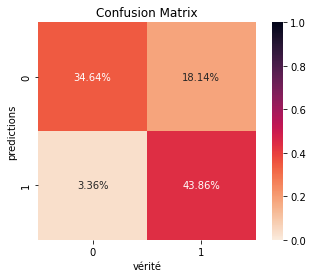

In [22]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(house2_power_blk1[features_col].values)
scaler.fit(house1_power_blk2.iloc[:24*60*60*15,:].loc[:, features_col].values)
X_test = scaler.transform(house1_power_blk2.iloc[24*60*60*15:,:].loc[:, features_col].values)

y_train = house2_power_blk1['activity'].values
y_test = house1_power_blk2.iloc[24*60*60*15:,:].loc[:, 'activity'].values

classifier = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12)
classifier.fit(X_train, y_train.ravel())
y_pred = classifier.predict(X_test)

mod.plot_confusion_matrix(y_test, y_pred);

# 3.3 Fitting scaler + re-fitting du modèle
L'idée est cette fois de fitter le scaler sur une partie de la maison 1 (test) mais aussi de re-fitter le modèle avec une partie des données test.

In [8]:
def classif_scale_fit_window(data_train, data_test, window=1, scaler=MinMaxScaler()):
    
    classifier=RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12, warm_start=True)
    X_train = scaler.fit_transform(data_train[features_col].values)
    # Attention : ici on re-fit le scaler sur les données du test
    X_test_known = scaler.fit_transform(data_test.iloc[:24*60*60*window,:].loc[:, features_col].values)
    X_test = scaler.transform(data_test.iloc[24*60*60*window:,:].loc[:, features_col].values)

    y_train = data_train['activity'].values
    y_test_known = data_test.iloc[:24*60*60*window,:].loc[:, 'activity'].values
    y_test = data_test.iloc[24*60*60*window:,:].loc[:, 'activity'].values

    classifier.fit(X_train, y_train.ravel())
    classifier.n_estimators += 30
    classifier.fit(X_test_known, y_test_known.ravel())
    y_pred = classifier.predict(X_test)

    f_beta = fbeta_score(y_test, y_pred, average="macro", beta=0.5)
    acc = accuracy_score(y_test, y_pred)

    return f_beta, acc

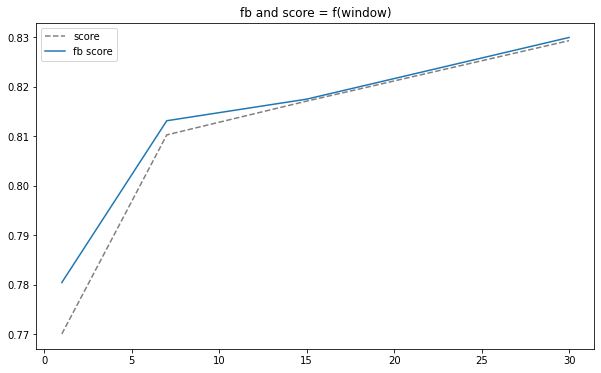

In [24]:
w_range = [1, 7, 15, 30]
fb_score = []
acc_score = []
for w in w_range:
    fb, acc = classif_scale_fit_window(house2_power_blk1, house1_power_blk2, window=w)
    fb_score.append(fb)
    acc_score.append(acc)

plt.figure(figsize=(10, 6));
plt.plot(w_range, acc_score, label='score', color='grey', linestyle='dashed');
plt.plot(w_range, fb_score, label='fb score');
plt.legend();
plt.title('fb and score = f(window)');

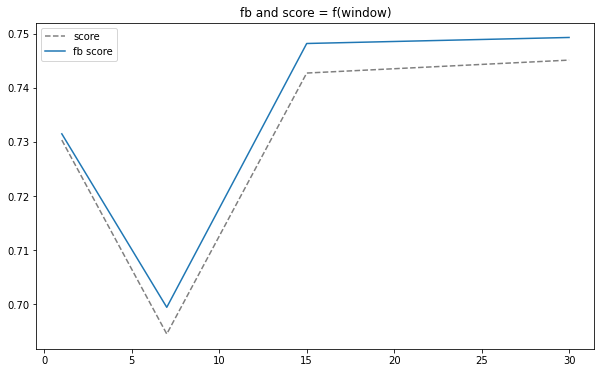

In [25]:
w_range = [1, 7, 15, 30]
fb_score = []
acc_score = []
for w in w_range:
    fb, acc = classif_scale_fit_window(house2_power_blk1, house1_power_blk2, window=w, scaler=StandardScaler())
    fb_score.append(fb)
    acc_score.append(acc)

plt.figure(figsize=(10, 6));
plt.plot(w_range, acc_score, label='score', color='grey', linestyle='dashed');
plt.plot(w_range, fb_score, label='fb score');
plt.legend();
plt.title('fb and score = f(window)');

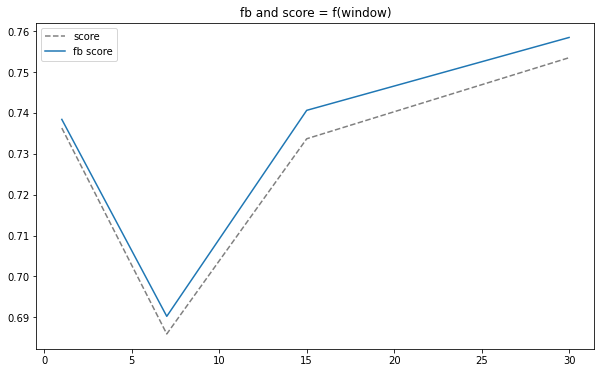

In [9]:
w_range = [1, 7, 15, 30]
fb_score = []
acc_score = []
for w in w_range:
    fb, acc = classif_scale_fit_window(house2_power_blk1, house1_power_blk2, window=w, scaler=QuantileTransformer())
    fb_score.append(fb)
    acc_score.append(acc)

plt.figure(figsize=(10, 6));
plt.plot(w_range, acc_score, label='score', color='grey', linestyle='dashed');
plt.plot(w_range, fb_score, label='fb score');
plt.legend();
plt.title('fb and score = f(window)');

Cette méthode nécessite néanmois d'avoir accès à une partie des données test labelisées. Une façon de contourner cela serait de considérer les périodes de nuit comme inactives et celles de jour comme actives mais cela représente une grosse approximation.

# 4. Self-training

In [5]:
def classif_self_training_window(data_train, data_test, window=1, scaler=MinMaxScaler()):
    
    classifier= SelfTrainingClassifier(RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12))
    X_train = scaler.fit_transform(data_train[features_col].values)
    # Attention : ici on re-fit le scaler sur les données du test
    X_test_known = scaler.fit_transform(data_test.iloc[:24*60*60*window,:].loc[:, features_col].values)
    X_test_unknown = scaler.transform(data_test.iloc[24*60*60*window:,:].loc[:, features_col].values)
    X = np.concatenate((X_train, X_test_unknown), axis=0)

    y_train = data_train['activity'].values
    y_test = data_test.iloc[24*60*60*window:,:].loc[:, 'activity'].values
    y_test_unknown = np.ones((y_test.shape[0],)) * -1

    y = np.concatenate((y_train, y_test_unknown), axis=0)

    classifier.fit(X, y.ravel())
    y_pred = classifier.predict(X_test_unknown)

    f_beta = fbeta_score(y_test, y_pred, average="macro", beta=0.5)
    acc = accuracy_score(y_test, y_pred)

    return f_beta, acc

done with w=1
done with w=7
done with w=15
done with w=30


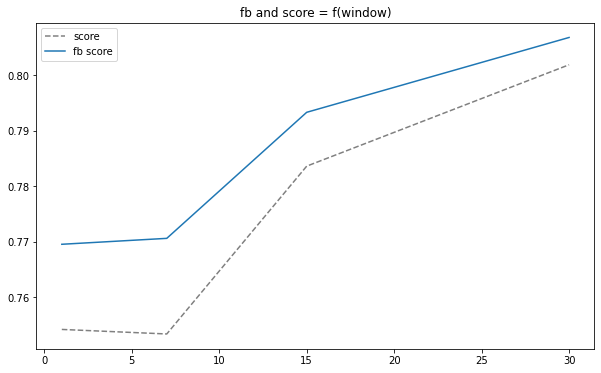

In [6]:
w_range = [1, 7, 15, 30]
fb_score = []
acc_score = []
for w in w_range:
    fb, acc = classif_self_training_window(house2_power_blk1, house1_power_blk2, window=w)
    fb_score.append(fb)
    acc_score.append(acc)
    print(f'done with w={w}')

plt.figure(figsize=(10, 6));
plt.plot(w_range, acc_score, label='score', color='grey', linestyle='dashed');
plt.plot(w_range, fb_score, label='fb score');
plt.legend();
plt.title('fb and score = f(window)');
